### 1. Import all the libraries and read the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import lightgbm as lgb
import xgboost as xgb
from Utils.calculate_metrics import calculate_multiclass_metrics

from joblib import dump, load
import warnings

warnings.filterwarnings('ignore')

In [22]:
train_data = pd.read_csv('./Data/train.csv', index_col='id')
test_data = pd.read_csv('./Data/test.csv', index_col='id')
train_data.shape, test_data.shape

((7200, 139), (800, 139))

### 2. Data preprocessing and Feature Engineering

In [20]:
def preprocess_base(data: pd.DataFrame):
    data = data.copy()
    data = data[data["happiness"] > 0]
    
    data.loc[:, "survey_month"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[1]).astype("int64")
    data.loc[:, "survey_day"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[2]).astype("int64")
    data.loc[:, "survey_hour"] = data["survey_time"].apply(lambda line: line.split(" ")[1].split(":")[0]).astype("int64")
    data = data.drop(columns='survey_time')
    
    data = data.drop(columns=['edu_other', 'property_other', 'invest_other', 'join_party'])
    data = data.fillna(0)
    
    label = data.pop('happiness')
    return data, label

def preprocess_relevance(train_data: pd.DataFrame, selected_features: list = None) -> pd.DataFrame:
    data = train_data.copy()
    data = data[data["happiness"] > 0]
    
    # Feature engineering
    data.loc[:, "survey_month"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[1]).astype("int64")
    data.loc[:, "survey_day"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[2]).astype("int64")
    data.loc[:, "survey_hour"] = data["survey_time"].apply(lambda line: line.split(" ")[1].split(":")[0]).astype("int64")
    data.loc[:, "age"] = 2015 - data["birth"]

    data = data.drop(columns='survey_time')
    data = data.drop(columns=['edu_other', 'property_other', 'invest_other', 'join_party'])

    # Replace NaN in specific columns with 0
    for column in ['work_status', 'work_yr', 'work_type', 'work_manage', 's_work_status', 's_work_type']:
        data.loc[data[column].isna(), column] = 0
    
    # Replace remaining NaN values with mode
    data = data.fillna(data.mode().iloc[0])

    # Replace negative values with the mode for integer columns
    for column in data.columns:
        if data[column].dtype == np.int64:
            data.loc[data[column] < 0, column] = data[column].mode().iloc[0]
    
    if selected_features is None:
        corr_matrix = data.corr(method='pearson', numeric_only=True)['happiness'][abs(data.corr(method='pearson', numeric_only=True)['happiness'])>0.05]
        features = corr_matrix.index.values.tolist()
        features.extend(['age'])  # Adding age explicitly as it is not necessarily part of correlation
        data_selected = data[features]
    else:
        selected_features.append('happiness')
        data_selected = data[selected_features]  # Ensure the selected features match

    label = data_selected.pop('happiness')
    return data_selected, label

def preprocessing_augmentation(train, test):
    train = train[train["happiness"]!=-8].reset_index(drop=True)
    train_data_copy = train.copy() #删去"happiness" 为-8的行
    target_col = "happiness" #目标列
    target = train_data_copy[target_col]

    test = test[test["happiness"]!=-8].reset_index(drop=True)
    test_label = test[target_col]



    del test['happiness']
    del train_data_copy[target_col] #去除目标列

    data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)
    # print(data.shape)

    #make feature +5
    #csv中有复数值：-1、-2、-3、-8，将他们视为有问题的特征，但是不删去
    def getres1(row):
        return len([x for x in row.values if type(x)==int and x<0])

    def getres2(row):
        return len([x for x in row.values if type(x)==int and x==-8])

    def getres3(row):
        return len([x for x in row.values if type(x)==int and x==-1])

    def getres4(row):
        return len([x for x in row.values if type(x)==int and x==-2])

    def getres5(row):
        return len([x for x in row.values if type(x)==int and x==-3])

    #检查数据
    data['neg1'] = data[data.columns].apply(lambda row:getres1(row),axis=1)
    data.loc[data['neg1']>20,'neg1'] = 20  #平滑处理

    data['neg2'] = data[data.columns].apply(lambda row:getres2(row),axis=1)
    data['neg3'] = data[data.columns].apply(lambda row:getres3(row),axis=1)
    data['neg4'] = data[data.columns].apply(lambda row:getres4(row),axis=1)
    data['neg5'] = data[data.columns].apply(lambda row:getres5(row),axis=1)

    #填充缺失值 共25列 去掉4列 填充21列
    #以下的列都是缺省的，视情况填补
    data['work_status'] = data['work_status'].fillna(0)
    data['work_yr'] = data['work_yr'].fillna(0)
    data['work_manage'] = data['work_manage'].fillna(0)
    data['work_type'] = data['work_type'].fillna(0)

    data['edu_yr'] = data['edu_yr'].fillna(0)
    data['edu_status'] = data['edu_status'].fillna(0)

    data['s_work_type'] = data['s_work_type'].fillna(0)
    data['s_work_status'] = data['s_work_status'].fillna(0)
    data['s_political'] = data['s_political'].fillna(0)
    data['s_hukou'] = data['s_hukou'].fillna(0)
    data['s_income'] = data['s_income'].fillna(0)
    data['s_birth'] = data['s_birth'].fillna(0)
    data['s_edu'] = data['s_edu'].fillna(0)
    data['s_work_exper'] = data['s_work_exper'].fillna(0)

    data['minor_child'] = data['minor_child'].fillna(0)
    data['marital_now'] = data['marital_now'].fillna(0)
    data['marital_1st'] = data['marital_1st'].fillna(0)
    data['social_neighbor']=data['social_neighbor'].fillna(0)
    data['social_friend']=data['social_friend'].fillna(0)
    data['hukou_loc']=data['hukou_loc'].fillna(1) #最少为1，表示户口
    data['family_income']=data['family_income'].fillna(66365) #删除问题值后的平均值

    #144+1 =145
    #继续进行特殊的列进行数据处理
    #读happiness_index.xlsx
    data['survey_time'] = pd.to_datetime(data['survey_time'], format='%Y-%m-%d',errors='coerce')#防止时间格式不同的报错errors='coerce‘
    data['survey_time'] = data['survey_time'].dt.year #仅仅是year，方便计算年龄
    data['age'] = data['survey_time']-data['birth']
    # print(data['age'],data['survey_time'],data['birth'])
    #年龄分层 145+1=146
    bins = [0,17,26,34,50,63,100]
    data['age_bin'] = pd.cut(data['age'], bins, labels=[0,1,2,3,4,5]) 

    #对‘宗教’处理
    data.loc[data['religion']<0,'religion'] = 1 #1为不信仰宗教
    data.loc[data['religion_freq']<0,'religion_freq'] = 1 #1为从来没有参加过
    #对‘教育程度’处理
    data.loc[data['edu']<0,'edu'] = 4 #初中
    data.loc[data['edu_status']<0,'edu_status'] = 0
    data.loc[data['edu_yr']<0,'edu_yr'] = 0
    #对‘个人收入’处理
    data.loc[data['income']<0,'income'] = 0 #认为无收入
    #对‘政治面貌’处理
    data.loc[data['political']<0,'political'] = 1 #认为是群众
    #对体重处理
    data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
    data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2  #个人的想法，哈哈哈，没有60斤的成年人吧
    #对身高处理
    data.loc[data['height_cm']<150,'height_cm'] = 150 #成年人的实际情况
    #对‘健康’处理
    data.loc[data['health']<0,'health'] = 4 #认为是比较健康
    data.loc[data['health_problem']<0,'health_problem'] = 4
    #对‘沮丧’处理
    data.loc[data['depression']<0,'depression'] = 4 #一般人都是很少吧
    #对‘媒体’处理
    data.loc[data['media_1']<0,'media_1'] = 1 #都是从不
    data.loc[data['media_2']<0,'media_2'] = 1
    data.loc[data['media_3']<0,'media_3'] = 1
    data.loc[data['media_4']<0,'media_4'] = 1
    data.loc[data['media_5']<0,'media_5'] = 1
    data.loc[data['media_6']<0,'media_6'] = 1
    #对‘空闲活动’处理
    data.loc[data['leisure_1']<0,'leisure_1'] = 1 #都是根据自己的想法
    data.loc[data['leisure_2']<0,'leisure_2'] = 5
    data.loc[data['leisure_3']<0,'leisure_3'] = 3

    data.loc[data['leisure_4']<0,'leisure_4'] = data['leisure_4'].mode() #取众数
    data.loc[data['leisure_5']<0,'leisure_5'] = data['leisure_5'].mode()
    data.loc[data['leisure_6']<0,'leisure_6'] = data['leisure_6'].mode()
    data.loc[data['leisure_7']<0,'leisure_7'] = data['leisure_7'].mode()
    data.loc[data['leisure_8']<0,'leisure_8'] = data['leisure_8'].mode()
    data.loc[data['leisure_9']<0,'leisure_9'] = data['leisure_9'].mode()
    data.loc[data['leisure_10']<0,'leisure_10'] = data['leisure_10'].mode()
    data.loc[data['leisure_11']<0,'leisure_11'] = data['leisure_11'].mode()
    data.loc[data['leisure_12']<0,'leisure_12'] = data['leisure_12'].mode()
    data.loc[data['socialize']<0,'socialize'] = 2 #很少
    data.loc[data['relax']<0,'relax'] = 4 #经常
    data.loc[data['learn']<0,'learn'] = 1 #从不，哈哈哈哈
    #对‘社交’处理
    data.loc[data['social_neighbor']<0,'social_neighbor'] = 0
    data.loc[data['social_friend']<0,'social_friend'] = 0
    data.loc[data['socia_outing']<0,'socia_outing'] = 1
    data.loc[data['neighbor_familiarity']<0,'social_neighbor']= 4
    #对‘社会公平性’处理
    data.loc[data['equity']<0,'equity'] = 4
    #对‘社会等级’处理
    data.loc[data['class_10_before']<0,'class_10_before'] = 3
    data.loc[data['class']<0,'class'] = 5
    data.loc[data['class_10_after']<0,'class_10_after'] = 5
    data.loc[data['class_14']<0,'class_14'] = 2
    #对‘工作情况’处理
    data.loc[data['work_status']<0,'work_status'] = 0
    data.loc[data['work_yr']<0,'work_yr'] = 0
    data.loc[data['work_manage']<0,'work_manage'] = 0
    data.loc[data['work_type']<0,'work_type'] = 0
    #对‘社会保障’处理
    data.loc[data['insur_1']<0,'insur_1'] = 1
    data.loc[data['insur_2']<0,'insur_2'] = 1
    data.loc[data['insur_3']<0,'insur_3'] = 1
    data.loc[data['insur_4']<0,'insur_4'] = 1
    data.loc[data['insur_1']==0,'insur_1'] = 0
    data.loc[data['insur_2']==0,'insur_2'] = 0
    data.loc[data['insur_3']==0,'insur_3'] = 0
    data.loc[data['insur_4']==0,'insur_4'] = 0

    #对家庭情况处理
    family_income_mean = data['family_income'].mean()
    data.loc[data['family_income']<0,'family_income'] = family_income_mean
    data.loc[data['family_m']<0,'family_m'] = 2
    data.loc[data['family_status']<0,'family_status'] = 3
    data.loc[data['house']<0,'house'] = 1
    data.loc[data['car']<0,'car'] = 0
    data.loc[data['car']==2,'car'] = 0 #变为0和1
    data.loc[data['son']<0,'son'] = 1
    data.loc[data['daughter']<0,'daughter'] = 0
    data.loc[data['minor_child']<0,'minor_child'] = 0
    #对‘婚姻’处理
    data.loc[data['marital_1st']<0,'marital_1st'] = 0
    data.loc[data['marital_now']<0,'marital_now'] = 0
    #对‘配偶’处理
    data.loc[data['s_birth']<0,'s_birth'] = 0
    data.loc[data['s_edu']<0,'s_edu'] = 0
    data.loc[data['s_political']<0,'s_political'] = 0
    data.loc[data['s_hukou']<0,'s_hukou'] = 0
    data.loc[data['s_income']<0,'s_income'] = 0
    data.loc[data['s_work_type']<0,'s_work_type'] = 0
    data.loc[data['s_work_status']<0,'s_work_status'] = 0
    data.loc[data['s_work_exper']<0,'s_work_exper'] = 0
    #对‘父母情况’处理
    data.loc[data['f_birth']<0,'f_birth'] = 1945
    data.loc[data['f_edu']<0,'f_edu'] = 1
    data.loc[data['f_political']<0,'f_political'] = 1
    data.loc[data['f_work_14']<0,'f_work_14'] = 2
    data.loc[data['m_birth']<0,'m_birth'] = 1940
    data.loc[data['m_edu']<0,'m_edu'] = 1
    data.loc[data['m_political']<0,'m_political'] = 1
    data.loc[data['m_work_14']<0,'m_work_14'] = 2
    #和同龄人相比社会经济地位
    data.loc[data['status_peer']<0,'status_peer'] = 2
    #和3年前比社会经济地位
    data.loc[data['status_3_before']<0,'status_3_before'] = 2
    #对‘观点’处理
    data.loc[data['view']<0,'view'] = 4
    #对期望年收入处理
    data.loc[data['inc_ability']<=0,'inc_ability']= 2
    inc_exp_mean = data['inc_exp'].mean()
    data.loc[data['inc_exp']<=0,'inc_exp']= inc_exp_mean #取均值

    #部分特征处理，取众数（首先去除缺失值的数据）
    for i in range(1, 9 + 1):
        mode_value = data['public_service_' + str(i)].dropna().mode().values[0]
        data.loc[data['public_service_' + str(i)] < 0, 'public_service_' + str(i)] = mode_value

    for i in range(1, 13 + 1):
        mode_value = data['trust_' + str(i)].dropna().mode().values[0]
        data.loc[data['trust_' + str(i)] < 0, 'trust_' + str(i)] = mode_value

    #第一次结婚年龄 147
    data['marital_1stbir'] = data['marital_1st'] - data['birth'] 
    #最近结婚年龄 148
    data['marital_nowtbir'] = data['marital_now'] - data['birth'] 
    #是否再婚 149
    data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']
    #配偶年龄 150
    data['marital_sbir'] = data['marital_now']-data['s_birth']
    #配偶年龄差 151
    data['age_'] = data['marital_nowtbir'] - data['marital_sbir'] 

    #收入比 151+7 =158
    data['income/s_income'] = data['income']/(data['s_income']+1) #同居伴侣
    data['income+s_income'] = data['income']+(data['s_income']+1)
    data['income/family_income'] = data['income']/(data['family_income']+1)
    data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
    data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
    data['family_income/m'] = data['family_income']/(data['family_m']+0.01)
    data['income/m'] = data['income']/(data['family_m']+0.01)

    #收入/面积比 158+4=162
    data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
    data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
    data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)
    data['floor_area/m'] = data['floor_area']/(data['family_m']+0.01)

    #class 162+3=165
    data['class_10_diff'] = (data['class_10_after'] - data['class'])
    data['class_diff'] = data['class'] - data['class_10_before']
    data['class_14_diff'] = data['class'] - data['class_14']
    #悠闲指数 166
    leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
    data['leisure_sum'] = data[leisure_fea_lis].sum(axis=1) #skew
    #满意指数 167
    public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
    data['public_service_sum'] = data[public_service_fea_lis].sum(axis=1) #skew

    #信任指数 168
    trust_fea_lis = ['trust_'+str(i) for i in range(1,14)]
    data['trust_sum'] = data[trust_fea_lis].sum(axis=1) #skew

    #province mean 168+13=181
    data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
    data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
    data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
    data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
    data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values
    data['province_health_mean'] = data.groupby(['province'])['health'].transform('mean').values
    data['province_class_10_diff_mean'] = data.groupby(['province'])['class_10_diff'].transform('mean').values
    data['province_class_mean'] = data.groupby(['province'])['class'].transform('mean').values
    data['province_health_problem_mean'] = data.groupby(['province'])['health_problem'].transform('mean').values
    data['province_family_status_mean'] = data.groupby(['province'])['family_status'].transform('mean').values
    data['province_leisure_sum_mean'] = data.groupby(['province'])['leisure_sum'].transform('mean').values
    data['province_public_service_sum_mean'] = data.groupby(['province'])['public_service_sum'].transform('mean').values
    data['province_trust_sum_mean'] = data.groupby(['province'])['trust_sum'].transform('mean').values

    #city   mean 181+13=194
    data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values #按照city分组
    data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
    data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
    data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
    data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values
    data['city_health_mean'] = data.groupby(['city'])['health'].transform('mean').values
    data['city_class_10_diff_mean'] = data.groupby(['city'])['class_10_diff'].transform('mean').values
    data['city_class_mean'] = data.groupby(['city'])['class'].transform('mean').values
    data['city_health_problem_mean'] = data.groupby(['city'])['health_problem'].transform('mean').values
    data['city_family_status_mean'] = data.groupby(['city'])['family_status'].transform('mean').values
    data['city_leisure_sum_mean'] = data.groupby(['city'])['leisure_sum'].transform('mean').values
    data['city_public_service_sum_mean'] = data.groupby(['city'])['public_service_sum'].transform('mean').values
    data['city_trust_sum_mean'] = data.groupby(['city'])['trust_sum'].transform('mean').values

    #county  mean 194 + 13 = 207
    data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
    data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
    data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
    data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
    data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values
    data['county_health_mean'] = data.groupby(['county'])['health'].transform('mean').values
    data['county_class_10_diff_mean'] = data.groupby(['county'])['class_10_diff'].transform('mean').values
    data['county_class_mean'] = data.groupby(['county'])['class'].transform('mean').values
    data['county_health_problem_mean'] = data.groupby(['county'])['health_problem'].transform('mean').values
    data['county_family_status_mean'] = data.groupby(['county'])['family_status'].transform('mean').values
    data['county_leisure_sum_mean'] = data.groupby(['county'])['leisure_sum'].transform('mean').values
    data['county_public_service_sum_mean'] = data.groupby(['county'])['public_service_sum'].transform('mean').values
    data['county_trust_sum_mean'] = data.groupby(['county'])['trust_sum'].transform('mean').values

    #ratio 相比同省 207 + 13 =220
    data['income/province'] = data['income']/(data['province_income_mean'])                                      
    data['family_income/province'] = data['family_income']/(data['province_family_income_mean'])   
    data['equity/province'] = data['equity']/(data['province_equity_mean'])       
    data['depression/province'] = data['depression']/(data['province_depression_mean'])                                                
    data['floor_area/province'] = data['floor_area']/(data['province_floor_area_mean'])
    data['health/province'] = data['health']/(data['province_health_mean'])
    data['class_10_diff/province'] = data['class_10_diff']/(data['province_class_10_diff_mean'])
    data['class/province'] = data['class']/(data['province_class_mean'])
    data['health_problem/province'] = data['health_problem']/(data['province_health_problem_mean'])
    data['family_status/province'] = data['family_status']/(data['province_family_status_mean'])
    data['leisure_sum/province'] = data['leisure_sum']/(data['province_leisure_sum_mean'])
    data['public_service_sum/province'] = data['public_service_sum']/(data['province_public_service_sum_mean'])
    data['trust_sum/province'] = data['trust_sum']/(data['province_trust_sum_mean']+1)

    #ratio 相比同市 220 + 13 =233
    data['income/city'] = data['income']/(data['city_income_mean'])                                      
    data['family_income/city'] = data['family_income']/(data['city_family_income_mean'])   
    data['equity/city'] = data['equity']/(data['city_equity_mean'])       
    data['depression/city'] = data['depression']/(data['city_depression_mean'])                                                
    data['floor_area/city'] = data['floor_area']/(data['city_floor_area_mean'])
    data['health/city'] = data['health']/(data['city_health_mean'])
    data['class_10_diff/city'] = data['class_10_diff']/(data['city_class_10_diff_mean'])
    data['class/city'] = data['class']/(data['city_class_mean'])
    data['health_problem/city'] = data['health_problem']/(data['city_health_problem_mean'])
    data['family_status/city'] = data['family_status']/(data['city_family_status_mean'])
    data['leisure_sum/city'] = data['leisure_sum']/(data['city_leisure_sum_mean'])
    data['public_service_sum/city'] = data['public_service_sum']/(data['city_public_service_sum_mean'])
    data['trust_sum/city'] = data['trust_sum']/(data['city_trust_sum_mean'])

    #ratio 相比同个地区 233 + 13 =246
    data['income/county'] = data['income']/(data['county_income_mean'])                                      
    data['family_income/county'] = data['family_income']/(data['county_family_income_mean'])   
    data['equity/county'] = data['equity']/(data['county_equity_mean'])       
    data['depression/county'] = data['depression']/(data['county_depression_mean'])                                                
    data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean'])
    data['health/county'] = data['health']/(data['county_health_mean'])
    data['class_10_diff/county'] = data['class_10_diff']/(data['county_class_10_diff_mean'])
    data['class/county'] = data['class']/(data['county_class_mean'])
    data['health_problem/county'] = data['health_problem']/(data['county_health_problem_mean'])
    data['family_status/county'] = data['family_status']/(data['county_family_status_mean'])
    data['leisure_sum/county'] = data['leisure_sum']/(data['county_leisure_sum_mean'])
    data['public_service_sum/county'] = data['public_service_sum']/(data['county_public_service_sum_mean'])
    data['trust_sum/county'] = data['trust_sum']/(data['county_trust_sum_mean'])

    #age   mean 246+ 13 =259
    data['age_income_mean'] = data.groupby(['age'])['income'].transform('mean').values
    data['age_family_income_mean'] = data.groupby(['age'])['family_income'].transform('mean').values
    data['age_equity_mean'] = data.groupby(['age'])['equity'].transform('mean').values
    data['age_depression_mean'] = data.groupby(['age'])['depression'].transform('mean').values
    data['age_floor_area_mean'] = data.groupby(['age'])['floor_area'].transform('mean').values
    data['age_health_mean'] = data.groupby(['age'])['health'].transform('mean').values
    data['age_class_10_diff_mean'] = data.groupby(['age'])['class_10_diff'].transform('mean').values
    data['age_class_mean'] = data.groupby(['age'])['class'].transform('mean').values
    data['age_health_problem_mean'] = data.groupby(['age'])['health_problem'].transform('mean').values
    data['age_family_status_mean'] = data.groupby(['age'])['family_status'].transform('mean').values
    data['age_leisure_sum_mean'] = data.groupby(['age'])['leisure_sum'].transform('mean').values
    data['age_public_service_sum_mean'] = data.groupby(['age'])['public_service_sum'].transform('mean').values
    data['age_trust_sum_mean'] = data.groupby(['age'])['trust_sum'].transform('mean').values

    # 和同龄人相比259 + 13 =272
    data['income/age'] = data['income']/(data['age_income_mean'])                                      
    data['family_income/age'] = data['family_income']/(data['age_family_income_mean'])   
    data['equity/age'] = data['equity']/(data['age_equity_mean'])       
    data['depression/age'] = data['depression']/(data['age_depression_mean'])                                                
    data['floor_area/age'] = data['floor_area']/(data['age_floor_area_mean'])
    data['health/age'] = data['health']/(data['age_health_mean'])
    data['class_10_diff/age'] = data['class_10_diff']/(data['age_class_10_diff_mean'])
    data['class/age'] = data['class']/(data['age_class_mean'])
    data['health_problem/age'] = data['health_problem']/(data['age_health_problem_mean'])
    data['family_status/age'] = data['family_status']/(data['age_family_status_mean'])
    data['leisure_sum/age'] = data['leisure_sum']/(data['age_leisure_sum_mean'])
    data['public_service_sum/age'] = data['public_service_sum']/(data['age_public_service_sum_mean'])
    data['trust_sum/age'] = data['trust_sum']/(data['age_trust_sum_mean'])
    #272-9=263
    #删除数值特别少的和之前用过的特征
    del_list=['id','survey_time','edu_other','invest_other','property_other','join_party','province','city','county']
    use_feature = [clo for clo in data.columns if clo not in del_list]
    data.fillna(0,inplace=True) #还是补0
    train_shape = train.shape[0] #一共的数据量，训练集
    features = data[use_feature].columns #删除后所有的特征
    X_train_263 = data[:train_shape][use_feature].values
    y_train = target
    y_test = test_label
    X_test_263 = data[train_shape:][use_feature].values
    X_train_263.shape #最终一种263个特征
    
    return X_train_263, y_train, X_test_263, y_test
    
    


In [15]:
train_df_base, train_label_base = preprocess_base(train_data)
test_df_base, test_label_base = preprocess_base(test_data)

train_df_relevance, train_label_relevance = preprocess_relevance(train_data)
test_df_relevance, test_label_relevance = preprocess_relevance(test_data, selected_features=train_df_relevance.columns.tolist())

train_df_aug, train_label_aug, test_df_aug, test_label_aug = preprocessing_augmentation(train_data, test_data)


train_df_base.shape, train_df_relevance.shape, train_df_aug.shape

((7190, 136), (7190, 75), (7190, 263))

### 3. Basic Modeling:

#### 3.1 Support Vector Machine (SVM)

**Our observations:**

- SVM can't handle such complex cases. It tends to predict the majority class (Happiness = 4).
- PCA can't improve the performance of SVM.

**Conclusion:** SVM is not a good choice for this dataset.

In [5]:
from sklearn import svm
from sklearn import metrics

svc_rbf1 = svm.SVC(kernel='rbf', C=1)
svc_rbf2 = svm.SVC(kernel='rbf', C=1)
svc_rbf3 = svm.SVC(kernel='rbf', C=1)

svc_rbf1.fit(train_df_base, train_label_base)
svc_rbf2.fit(train_df_relevance, train_label_relevance)
svc_rbf3.fit(train_df_aug, train_label_aug)

predict_base = svc_rbf1.predict(test_df_base)
predict_relevance = svc_rbf2.predict(test_df_relevance)
predict_aug = svc_rbf3.predict(test_df_aug)


metric1 = calculate_multiclass_metrics(test_label_base, predict_base)
metric2 = calculate_multiclass_metrics(test_label_relevance, predict_relevance)
metric3 = calculate_multiclass_metrics(test_label_aug, predict_aug)

metric1, metric2, metric3


({'MSE': 0.7894736842105263,
  'Accuracy': 0.5726817042606517,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
   3: {'TP': 0, 'TN': 671, 'FP': 1, 'FN': 126},
   4: {'TP': 457, 'TN': 0, 'FP': 340, 'FN': 1},
   5: {'TP': 0, 'TN': 657, 'FP': 0, 'FN': 141}},
  'Unrounded MSE': 0.7894736842105263},
 {'MSE': 0.7882205513784462,
  'Accuracy': 0.5739348370927319,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
   3: {'TP': 0, 'TN': 672, 'FP': 0, 'FN': 126},
   4: {'TP': 458, 'TN': 0, 'FP': 340, 'FN': 0},
   5: {'TP': 0, 'TN': 657, 'FP': 0, 'FN': 141}},
  'Unrounded MSE': 0.7882205513784462},
 {'MSE': 0.7894736842105263,
  'Accuracy': 0.5726817042606517,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
   3: {'TP': 0, 'TN': 671, 'FP': 1, 'FN': 126},
   4: {'TP': 457, 'TN': 0, 'FP': 340, 'FN': 1},
   5: {'TP':

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 20)
reduced_train = pca.fit_transform(train_df_base)
reduced_test = pca.fit_transform(test_df_base)



svc_rbf = svm.SVC(kernel='rbf')
svc_rbf.fit(reduced_train, train_label_base)

predict = svc_rbf.predict(reduced_test)

metric = calculate_multiclass_metrics(test_label_base, predict)
metric

{'MSE': 0.7894736842105263,
 'Accuracy': 0.5726817042606517,
 'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
  2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
  3: {'TP': 0, 'TN': 671, 'FP': 1, 'FN': 126},
  4: {'TP': 457, 'TN': 0, 'FP': 340, 'FN': 1},
  5: {'TP': 0, 'TN': 657, 'FP': 0, 'FN': 141}},
 'Unrounded MSE': 0.7894736842105263}

### 3.2 Ridge Regression

**Our observations:**
- Betther than SVM when it comes to the mse. 
- Perform poorly in terms of the accuracy.
- It seems underfit or the model is too simple for this dataset. We try to evaluate the model with training data but the model is not able to capture the complexity of the data.

**Conclusion:**
Ridge Regression is not a good choice for this dataset.

In [ ]:
from sklearn import linear_model

ridge1 = linear_model.Ridge()
ridge2 = linear_model.Ridge()
ridge3 = linear_model.Ridge()

ridge1.fit(train_df_base, train_label_base)
ridge2.fit(train_df_relevance, train_label_relevance)
ridge3.fit(train_df_aug, train_label_aug)

predict_base = ridge1.predict(test_df_base)
predict_relevance = ridge2.predict(test_df_relevance)
predict_aug = ridge3.predict(test_df_aug)

metric1 = calculate_multiclass_metrics(test_label_base, predict_base)
metric2 = calculate_multiclass_metrics(test_label_relevance, predict_relevance)
metric3 = calculate_multiclass_metrics(test_label_aug, predict_aug)

metric1, metric2, metric3


({'MSE': 0.6265664160401002,
  'Accuracy': 0.5764411027568922,
  'Class Metrics': {1: {'TP': 0, 'TN': 783, 'FP': 1, 'FN': 14},
   2: {'TP': 1, 'TN': 736, 'FP': 3, 'FN': 58},
   3: {'TP': 47, 'TN': 565, 'FP': 107, 'FN': 79},
   4: {'TP': 393, 'TN': 122, 'FP': 218, 'FN': 65},
   5: {'TP': 19, 'TN': 648, 'FP': 9, 'FN': 122}},
  'Unrounded MSE': 0.5970765370129127},
 {'MSE': 0.5827067669172933,
  'Accuracy': 0.5764411027568922,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 735, 'FP': 4, 'FN': 59},
   3: {'TP': 45, 'TN': 562, 'FP': 110, 'FN': 81},
   4: {'TP': 389, 'TN': 127, 'FP': 213, 'FN': 69},
   5: {'TP': 26, 'TN': 646, 'FP': 11, 'FN': 115}},
  'Unrounded MSE': 0.5361733605323077},
 {'MSE': 0.5977443609022557,
  'Accuracy': 0.5802005012531328,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 734, 'FP': 5, 'FN': 59},
   3: {'TP': 53, 'TN': 559, 'FP': 113, 'FN': 73},
   4: {'TP': 385, 'TN': 138, 'FP': 202, 'FN':

### 3.3 Logistic Regression

**Our observations:**
- Similar to SVM, Logistic Regression can't handle such complex cases. It tends to predict the majority class (Happiness = 4).
- PCA will even make the performance worse.

**Conclusion:** 
Logistic Regression is not a good choice for this dataset.

In [11]:
from sklearn import linear_model    
from sklearn import metrics

logistic1 = linear_model.LogisticRegression()
logistic2 = linear_model.LogisticRegression()
logistic3 = linear_model.LogisticRegression()

logistic1.fit(train_df_base, train_label_base)
logistic2.fit(train_df_relevance, train_label_relevance)
logistic3.fit(train_df_aug, train_label_aug)

predict_base = logistic1.predict(test_df_base)
predict_relevance = logistic2.predict(test_df_relevance)
predict_aug = logistic3.predict(test_df_aug)

metric1 = calculate_multiclass_metrics(test_label_base, predict_base)
metric2 = calculate_multiclass_metrics(test_label_relevance, predict_relevance)
metric3 = calculate_multiclass_metrics(test_label_aug, predict_aug)

metric1, metric2, metric3

({'MSE': 0.7894736842105263,
  'Accuracy': 0.5726817042606517,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
   3: {'TP': 0, 'TN': 671, 'FP': 1, 'FN': 126},
   4: {'TP': 457, 'TN': 0, 'FP': 340, 'FN': 1},
   5: {'TP': 0, 'TN': 657, 'FP': 0, 'FN': 141}},
  'Unrounded MSE': 0.7894736842105263},
 {'MSE': 0.7882205513784462,
  'Accuracy': 0.5739348370927319,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
   3: {'TP': 0, 'TN': 672, 'FP': 0, 'FN': 126},
   4: {'TP': 458, 'TN': 0, 'FP': 340, 'FN': 0},
   5: {'TP': 0, 'TN': 657, 'FP': 0, 'FN': 141}},
  'Unrounded MSE': 0.7882205513784462},
 {'MSE': 0.7894736842105263,
  'Accuracy': 0.5726817042606517,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
   3: {'TP': 0, 'TN': 671, 'FP': 1, 'FN': 126},
   4: {'TP': 457, 'TN': 0, 'FP': 340, 'FN': 1},
   5: {'TP':

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 20)
reduced_train = pca.fit_transform(train_df_base)
reduced_test = pca.fit_transform(test_df_base)

logistic = linear_model.LogisticRegression()
logistic.fit(reduced_train, train_label_base)

predict = logistic.predict(reduced_test)

mse = metrics.mean_squared_error(test_label_base, predict)
accuracy = metrics.accuracy_score(test_label_base, predict)

print('MSE:', mse, end=' ')
print('Accuracy:', accuracy)



MSE: 0.9122807017543859 Accuracy: 0.41854636591478694


### 4. Advanced Modeling:

#### 4.1 LightGBM

##### 4.1.1 Contrast the performance of different feature engineering techniques

In [26]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import  KFold
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


mse1 = []
accs1 = []
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

for train, test in kf.split(train_df_base, train_label_base):
    x_train = train_df_base.iloc[train]
    y_train = train_label_base.iloc[train]
    x_test = train_df_base.iloc[test]
    y_test = train_label_base.iloc[test]
    
    
    model = lgb.LGBMRegressor(n_estimators=10000)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    mse1.append(metrics.mean_squared_error(y_test, y_pred))
    accs1.append(metrics.accuracy_score(y_test, np.round(y_pred)))

mse2 = []
accs2 = []

for train, test in kf.split(train_df_relevance, train_label_relevance):
    x_train = train_df_relevance.iloc[train]
    y_train = train_label_relevance.iloc[train]
    x_test = train_df_relevance.iloc[test]
    y_test = train_label_relevance.iloc[test]
    
    
    model = lgb.LGBMRegressor(n_estimators=10000)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    mse2.append(metrics.mean_squared_error(y_test, y_pred))
    accs2.append(metrics.accuracy_score(y_test, np.round(y_pred)))
    
mse3 = []
accs3 = []

for train, test in kf.split(train_df_aug, train_label_aug):
    x_train = train_df_aug[train]
    y_train = train_label_aug[train]
    x_test = train_df_aug[test]
    y_test = train_label_aug[test]
    
    
    model = lgb.LGBMRegressor(n_estimators=10000)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    mse3.append(metrics.mean_squared_error(y_test, y_pred))
    accs3.append(metrics.accuracy_score(y_test, np.round(y_pred)))
    
    
print('MSE1:', np.mean(mse1), end=' ')
print('Accuracy1:', np.mean(accs1))
print('MSE2:', np.mean(mse2), end=' ')
print('Accuracy2:', np.mean(accs2))
print('MSE3:', np.mean(mse3), end=' ')
print('Accuracy3:', np.mean(accs3))





MSE1: 0.4850354657588934 Accuracy1: 0.6015299026425591
MSE2: 0.49420856006434544 Accuracy2: 0.5948539638386648
MSE3: 0.4725713544634913 Accuracy3: 0.6122392211404728


**Using Grid Search for Simple Hyperparameter Tuning of LGBM**  
- Omit most of the tuning process, simply to demonstrate hyperparameter tuning using Grid Search.

In [ ]:
from sklearn import model_selection

## Params 1
lgbR = lgb.LGBMRegressor(n_estimators=1000)
param_test = {
'boosting_type':['gbdt','dart','goss'], 
}

clf = model_selection.GridSearchCV(lgbR,param_test ,cv=10,n_jobs=-1,scoring='neg_mean_squared_error')
clf.fit(train_df_base, train_label_base)

print("clf.cv_results_['mean_test_score']:=%s"%clf.cv_results_['mean_test_score'])

print(clf.best_score_)
print(clf.best_params_)


## Params 2
lgbR = lgb.LGBMRegressor(n_estimators=1000)
param_test = {
 'max_depth':range(1,10,2),
 'min_child_weight':[0.001,0.01,1,10]  
}
clf=model_selection.GridSearchCV(lgbR,param_test,cv=10,n_jobs=-1,scoring='neg_mean_squared_error')
clf.fit(train_df_base, train_label_base)

print("clf.cv_results_['mean_test_score']:=%s"%clf.cv_results_['mean_test_score'])
print(clf.best_score_)
print(clf.best_params_)



##### 4.1.2 LGBM with hyperparameter tuning

In [62]:
oof_preds = np.zeros(train_df_aug.shape[0])
kf = KFold(n_splits=5, shuffle=True, random_state=42)  


for fold_, (train_idx, val_idx) in enumerate(kf.split(train_df_aug)):
    print(f"Fold {fold_ + 1}")
    
    x_train, y_train = train_df_aug[train_idx], train_label_aug[train_idx]
    x_val, y_val = train_df_aug[val_idx], train_label_aug[val_idx]
    
    model = lgb.LGBMRegressor(
        num_leaves=7,
        min_data_in_leaf=20,
        objective='regression',
        max_depth=-1,
        learning_rate=0.003,
        boosting='gbdt',
        feature_fraction=0.18,
        bagging_freq=1,
        bagging_fraction=0.55,
        bagging_seed=14,
        metric='mse',
        lambda_l1=0.1,
        lambda_l2=0.2,
        verbosity=-1,
        n_estimators=10000
    )
    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    
    oof_preds[val_idx] = y_pred
    
calculate_multiclass_metrics(train_label_aug, oof_preds)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


{'MSE': 0.5015299026425591,
 'Accuracy': 0.621279554937413,
 'Class Metrics': {1: {'TP': 6, 'TN': 7098, 'FP': 2, 'FN': 84},
  2: {'TP': 31, 'TN': 6684, 'FP': 68, 'FN': 407},
  3: {'TP': 378, 'TN': 5421, 'FP': 736, 'FN': 655},
  4: {'TP': 3836, 'TN': 1025, 'FP': 1805, 'FN': 524},
  5: {'TP': 216, 'TN': 5809, 'FP': 112, 'FN': 1053}},
 'Unrounded MSE': 0.4470770973766928}

##### 4.1.3 Use lgbm to extract the least 20 important features


Feature Importance (Base):
       feature  importance
55      equity         108
28  depression          75
14  floor_area          75
25  weight_jin          71
2         city          65
..         ...         ...
22  property_7           0
21  property_6           0
20  property_5           0
82    invest_8           0
15  property_0           0

[136 rows x 2 columns]


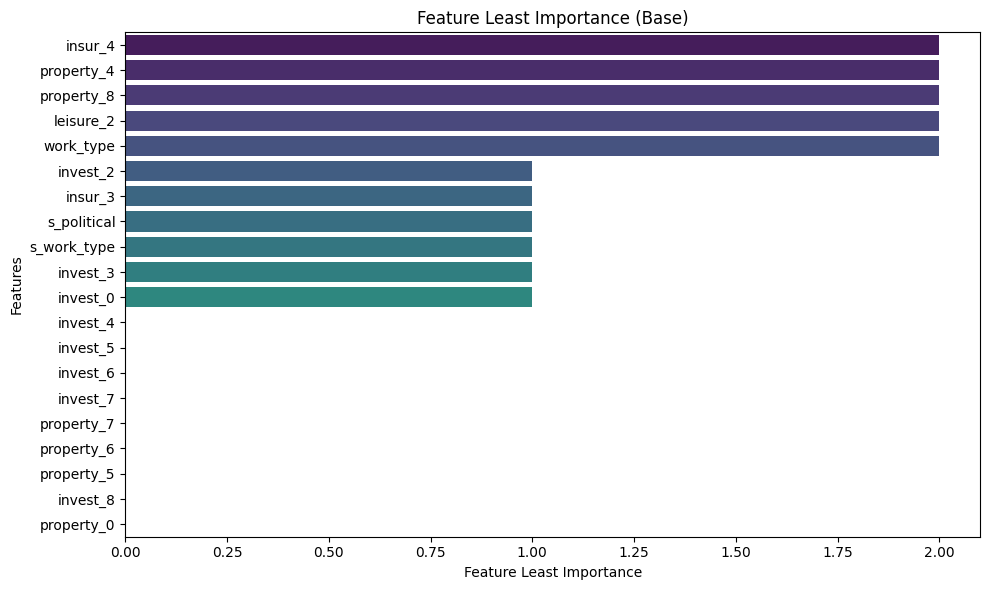

In [33]:
import seaborn as sns


model = lgb.LGBMRegressor()
model.fit(train_df_base, train_label_base)


importance_base = pd.DataFrame({
    'feature': train_df_base.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)


# 打印结果

print("\nFeature Importance (Base):")
print(importance_base)

def plot_feature_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="importance", 
        y="feature", 
        data=importance_df.tail(20), 
        palette="viridis"
    )
    plt.title(title)
    plt.xlabel("Feature Least Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    
plot_feature_importance(importance_base, "Feature Least Importance (Base)")


#### 4.2 XGBoost
##### 4.2.1 XGBoost without hyperparameter tuning

In [54]:
import xgboost as xgb


mse1 = []
accs1 = []
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

for train, test in kf.split(train_df_base, train_label_base):
    x_train = train_df_base.iloc[train]
    y_train = train_label_base.iloc[train]
    x_test = train_df_base.iloc[test]
    y_test = train_label_base.iloc[test]
    
    model = xgb.XGBRegressor(n_estimators=1000)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    mse1.append(metrics.mean_squared_error(y_test, y_pred))
    accs1.append(metrics.accuracy_score(y_test, np.round(y_pred)))

mse2 = []
accs2 = []

for train, test in kf.split(train_df_relevance, train_label_relevance):
    x_train = train_df_relevance.iloc[train]
    y_train = train_label_relevance.iloc[train]
    x_test = train_df_relevance.iloc[test]
    y_test = train_label_relevance.iloc[test]
    
    model = xgb.XGBRegressor(n_estimators=1000)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    mse2.append(metrics.mean_squared_error(y_test, y_pred))
    accs2.append(metrics.accuracy_score(y_test, np.round(y_pred)))
    
mse3 = []
accs3 = []

for train, test in kf.split(train_df_aug, train_label_aug):
    x_train = train_df_aug[train]
    y_train = train_label_aug[train]
    x_test = train_df_aug[test]
    y_test = train_label_aug[test]
    
    model = xgb.XGBRegressor(n_estimators=1000)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    mse3.append(metrics.mean_squared_error(y_test, y_pred))
    accs3.append(metrics.accuracy_score(y_test, np.round(y_pred)))



print('MSE1:', np.mean(mse1), end=' ')
print('Accuracy1:', np.mean(accs1))
print('MSE2:', np.mean(mse2), end=' ')
print('Accuracy2:', np.mean(accs2))
print('MSE3:', np.mean(mse3), end=' ')
print('Accuracy3:', np.mean(accs3))

MSE1: 0.5337683960917979 Accuracy1: 0.5773296244784423
MSE2: 0.5365861993776015 Accuracy2: 0.5738525730180808
MSE3: 0.5107066991378596 Accuracy3: 0.5852573018080667


##### 4.2.2 XGBoost with hyperparameter tuning

In [63]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(train_df_aug.shape[0])


for train, test in kf.split(train_df_aug, train_label_aug):
    x_train = train_df_aug[train]
    y_train = train_label_aug[train]
    x_test = train_df_aug[test]
    y_test = train_label_aug[test]
    xgboost_modified=xgb.XGBRegressor(max_depth=4,min_child_weight=0.5,gamma=0.4,subsample=0.7,colsample_bytree=0.8,reg_alpha=1,reg_lambda=0.001, learning_rate=0.1) 
    xgboost_modified.fit(x_train, y_train)
    
    y_pred = xgboost_modified.predict(x_test)
    oof_preds[test] = y_pred

    
calculate_multiclass_metrics(train_label_aug, oof_preds)


{'MSE': 0.5159944367176634,
 'Accuracy': 0.6154381084840056,
 'Class Metrics': {1: {'TP': 3, 'TN': 7098, 'FP': 2, 'FN': 87},
  2: {'TP': 35, 'TN': 6689, 'FP': 63, 'FN': 403},
  3: {'TP': 370, 'TN': 5408, 'FP': 749, 'FN': 663},
  4: {'TP': 3820, 'TN': 994, 'FP': 1836, 'FN': 540},
  5: {'TP': 197, 'TN': 5806, 'FP': 115, 'FN': 1072}},
 'Unrounded MSE': 0.4550743153367549}

### 5. AutoML: Autogluon

#### 5.1 Training the model

> Note: Since the training process is time-consuming and computationally expensive, all the code is run on the server. The code is provided here for reference.

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np

data = pd.read_csv('./data/train.csv', encoding='gb2312')

## 数据预处理
data = data[data["happiness"] > 0]
    
data.loc[:, "survey_month"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[1]).astype("int64")
data.loc[:, "survey_day"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[2]).astype("int64")
data.loc[:, "survey_hour"] = data["survey_time"].apply(lambda line: line.split(" ")[1].split(":")[0]).astype("int64")
data = data.drop(columns='survey_time')

data = data.drop(columns=['edu_other', 'property_other', 'invest_other', 'join_party'])

for column in ['work_status', 'work_yr', 'work_type', 'work_manage', 's_work_status', 's_work_type']:
    data.loc[data[column].isna(), column] = 0

data = data.fillna(data.mode().iloc[0])
for column in data.columns:
    if data[column].dtype == np.int64:
        data.loc[data[column] < 0, column] = data[column].mode().iloc[0]



train_data = TabularDataset(data)


id, label = 'id', 'happiness'

predictor = TabularPredictor(label=label, 
                             eval_metric='mse',
                             problem_type='regression').fit(train_data.drop(columns=[id]),
                                   presets='best_quality',
                                    ag_args_fit={'num_gpus': 1})


print("AutoGluon training completed. Model is saved as AutoGluon_model/")

#### 5.2 Prediction 

In [ ]:
import pandas as pd
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn import metrics

data = pd.read_csv('./data/test.csv')
data["survey_month"] = data["survey_time"].transform(lambda line:line.split(" ")[0].split("/")[1]).astype("int64")   #返回调查月：用空格来切分日期和时间，日期中第1项为月
data["survey_day"] = data["survey_time"].transform(lambda line:line.split(" ")[0].split("/")[2]).astype("int64")   #返回调查日
data["survey_hour"] = data["survey_time"].transform(lambda line:line.split(" ")[1].split(":")[0]).astype("int64")   #返回调查小时
data=data.drop(columns='survey_time')


data = data.drop(columns=['edu_other', 'property_other', 'invest_other', 'join_party'])

for column in ['work_status', 'work_yr', 'work_type', 'work_manage', 's_work_status', 's_work_type']:
    data.loc[data[column].isna(), column] = 0

data = data.fillna(data.mode().iloc[0])


test_data = TabularDataset(data)
predictor = TabularPredictor.load('AutogluonModels/ag-20250103_172351')

preds = predictor.predict(test_data.drop(columns=['id']))

mse = metrics.mean_squared_error(data['happiness'], preds)
print(f"Mean Squared Error: {mse}")

preds = round(preds)
rounded_mse = metrics.mean_squared_error(data['happiness'], preds)
print(f"Rounded Mean Squared Error: {rounded_mse}")

accuracy = metrics.accuracy_score(data['happiness'], preds)
print(f"Accuracy: {accuracy}")





We can see that the autogluon model is able to predict the happiness score with the  **highest accuracy**.

In [64]:
import pandas as pd
import numpy as np
from sklearn import metrics

res = pd.read_csv('./data/submission.csv')
preds = res['happiness']

test_data = pd.read_csv('./data/test.csv')
label = test_data['happiness']

calculate_multiclass_metrics(label, preds)

{'MSE': 0.625,
 'Accuracy': 0.69,
 'Class Metrics': {1: {'TP': 0, 'TN': 786, 'FP': 0, 'FN': 14},
  2: {'TP': 11, 'TN': 725, 'FP': 16, 'FN': 48},
  3: {'TP': 64, 'TN': 594, 'FP': 80, 'FN': 62},
  4: {'TP': 425, 'TN': 193, 'FP': 149, 'FN': 33},
  5: {'TP': 52, 'TN': 656, 'FP': 3, 'FN': 89}},
 'Unrounded MSE': 0.625}